# Imports

In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install -U datasets

In [ ]:
import transformers
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Data

The data set contains input_text in the form of symptoms that are considered by the patient and subjected to diagnoses.
Data set

Data set source [huggingface](https://huggingface.co/datasets/gretelai/symptom_to_diagnosis)

In [ ]:
dataset = load_dataset("gretelai/symptom_to_diagnosis")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['output_text', 'input_text'],
        num_rows: 853
    })
    test: Dataset({
        features: ['output_text', 'input_text'],
        num_rows: 212
    })
})

In [ ]:
dataset=dataset.rename_column('output_text', 'label').rename_column('input_text', 'text')

In [ ]:
example_text = dataset['train'][1]['text']
example_label = dataset['train'][1]['label']

Przykład z zbioru treningowego wraz z etykietą

In [ ]:
print(example_text)
print(f'label: {example_label}')

I have a rash on my face that is getting worse. It is red, inflamed, and has blisters that are bleeding clear pus. It is really painful.
label: impetigo


In [ ]:
df_train=pd.DataFrame.from_dict(dataset['train'])

In [ ]:
df_train.shape

(853, 2)

The average length of input_text is 150a, the general range is 55-285

In [ ]:
print(f'Średnia długość input_text: {df_train["text"].str.len().mean()}')
print(f'Min długość input_text: {df_train["text"].str.len().min()}')
print(f'Max długość input_text: {df_train["text"].str.len().max()}')

Średnia długość input_text: 150.0082063305979
Min długość input_text: 55
Max długość input_text: 285



There is an equal distribution of classes in the data among 22 categories, the data are balanced.

In [ ]:
print(f'Liczba kategorii: {len(df_train["label"].unique())}')

Liczba kategorii: 22


In [ ]:
df_train['label'].value_counts()

label
cervical spondylosis               40
allergy                            40
chicken pox                        40
diabetes                           40
psoriasis                          40
hypertension                       40
impetigo                           40
bronchial asthma                   40
varicose veins                     40
malaria                            40
drug reaction                      40
dengue                             40
arthritis                          40
fungal infection                   39
common cold                        39
gastroesophageal reflux disease    39
urinary tract infection            39
typhoid                            38
pneumonia                          37
peptic ulcer disease               37
jaundice                           33
migraine                           32
Name: count, dtype: int64

# Model Bert

In [ ]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 64

Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 853
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 212
    })
})

In [ ]:
def process(dataset):
  return tokenizer(dataset['text'])

train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

In [ ]:
train_ds

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 853
})

# Bert fine tuning

laabel encoder

In [ ]:
label_encoder = LabelEncoder()

label_train=label_encoder.fit_transform(train_ds['label'])
label_test=label_encoder.transform(test_ds['label'])

train_ds = train_ds.remove_columns('label')
train_ds = train_ds.add_column('label', label_train)

test_ds = test_ds.remove_columns('label')
test_ds = test_ds.add_column('label', label_test)

In [ ]:
num_labels = 22
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training arguments: 20 epochs with early stopping, learning_rate slightly higher than the base one works better in this case. steps = 50 apparently early stopping does not work after epochs

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_classification',
    evaluation_strategy = 'steps',
    eval_steps = 50,
    save_strategy = 'steps',
    learning_rate = 2e-4,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 20,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss'
)

Ewaluation

In [ ]:

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


trening

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.evaluate([train_ds[0]])

{'eval_loss': 3.061356782913208,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.021,
 'eval_samples_per_second': 47.537,
 'eval_steps_per_second': 47.537}

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,No log,0.291442,0.943396
100,No log,0.207562,0.957547
150,No log,0.179195,0.952830
200,No log,0.100615,0.962264
250,No log,0.094653,0.962264


TrainOutput(global_step=280, training_loss=0.29044298444475447, metrics={'train_runtime': 93.7432, 'train_samples_per_second': 181.987, 'train_steps_per_second': 2.987, 'total_flos': 287441607992460.0, 'train_loss': 0.29044298444475447, 'epoch': 20.0})

Test

In [ ]:
pr = trainer.predict(test_ds)

In [ ]:
pr

PredictionOutput(predictions=array([[-1.8427873 , -1.5164351 , -1.867207  , ..., -1.6409711 ,
        -1.1499262 , -0.7330751 ],
       [-1.8397233 , -1.7836807 , -1.5880076 , ..., -0.97567487,
        -0.96963483, -0.78429925],
       [-2.719376  , -0.4501806 , -2.7951896 , ..., -1.0033436 ,
        -2.4412956 , -1.4977493 ],
       ...,
       [-2.1598184 , -1.8600755 ,  8.176122  , ..., -1.1640977 ,
        -0.8451119 , -2.5301003 ],
       [-2.415579  , -2.3618171 ,  5.9270453 , ..., -2.0370603 ,
        -1.1900953 , -2.0366426 ],
       [-2.9332669 , -0.96691906, -2.2541935 , ..., -0.39794827,
        -1.7451724 , -1.5705713 ]], dtype=float32), label_ids=array([16, 16,  8, 17,  9,  3, 10, 18,  1, 17,  1,  3, 14, 19, 16, 14, 15,
        2,  7, 13, 15, 14, 10, 14,  4,  1, 20,  4,  9, 13, 19,  3, 17,  2,
        4, 10, 12, 11, 19,  9,  5, 11,  1, 12, 15,  8,  7, 17, 20,  6,  6,
        4, 15,  3, 14, 13, 14,  5,  7, 17, 10,  2, 21,  5, 10, 18,  3, 16,
        7,  7,  5,  5, 20, 13, 1

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(pr.label_ids, np.argmax(pr.predictions, axis=1))
print(confusion)


[[ 9  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

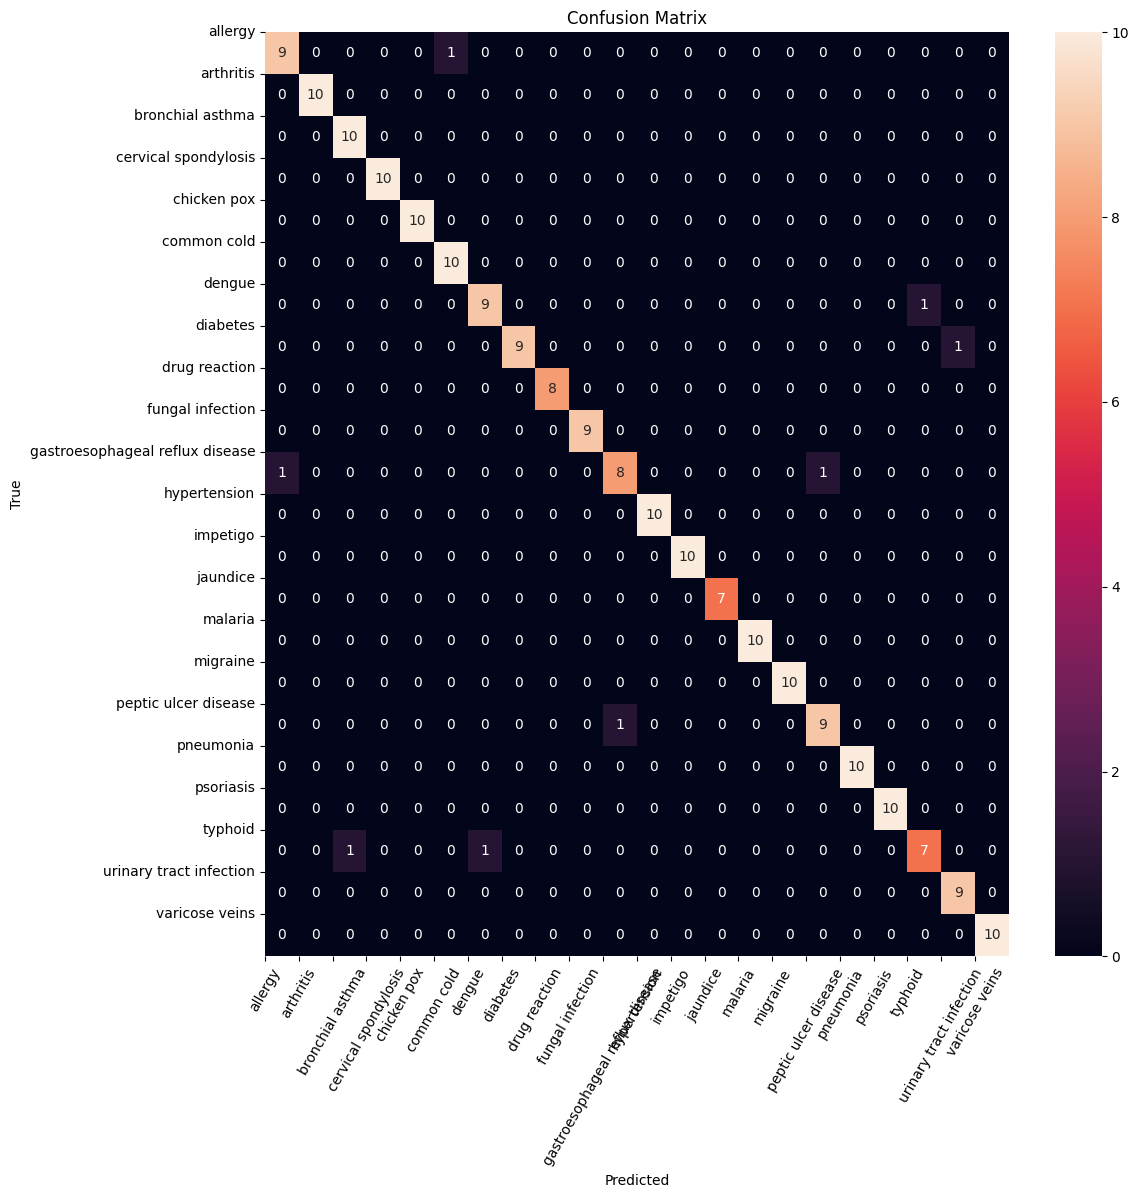

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
sns.heatmap(confusion, annot=True)

plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=60)
plt.yticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test on new sympthons

In [ ]:
label_encoder.classes_

array(['allergy', 'arthritis', 'bronchial asthma', 'cervical spondylosis',
       'chicken pox', 'common cold', 'dengue', 'diabetes',
       'drug reaction', 'fungal infection',
       'gastroesophageal reflux disease', 'hypertension', 'impetigo',
       'jaundice', 'malaria', 'migraine', 'peptic ulcer disease',
       'pneumonia', 'psoriasis', 'typhoid', 'urinary tract infection',
       'varicose veins'], dtype='<U31')

In [ ]:
import torch

In [ ]:

def make_diagnose(text):
  inputs = tokenizer(text, return_tensors='pt')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)


  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

  #print(predictions.item())
  print(f'this symptoms could be {label_encoder.inverse_transform([predictions.item()])}')



In [ ]:
text='My nose is stuffy and I sneeze all the time and my eyes are red.'
make_diagnose(text)

this symptoms could be ['allergy']


In [ ]:
text='For some time now I have noticed that I often feel intense thirst and dry mouth, even after drinking plenty of water. Recently, I have also noticed that my skin is more susceptible to infections and my wounds are healing slower than usual.'
make_diagnose(text)

this symptoms could be ['diabetes']


In [ ]:
text='I have a very high fever and all my muscles and spine hurt'
make_diagnose(text)

this symptoms could be ['dengue']


# Bert feature extraction


Re-tokenization, without return_tensors='pt': instead of pytorch the tensor returns a list and causes an error when checking the size in 'input_shape = input_ids.size()'

In [ ]:
#tokenizer(dataset['train']['text'])

In [ ]:
token_train=tokenizer(dataset['train']['text'], padding=True, truncation=True, return_tensors='pt')
token_test=tokenizer(dataset['test']['text'], padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



reloading the model from hiden_states I also checked that logits can be used without reloading

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
with torch.no_grad():
    hidden_train = model(**token_train)
    hidden_test = model(**token_test)


In [ ]:
hidden_train

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0593, -0.0421, -0.0338,  ..., -0.0401,  0.0102, -0.0344],
        [ 0.0624, -0.0344, -0.0348,  ..., -0.0303,  0.0392, -0.0325],
        [ 0.0271, -0.0956, -0.0407,  ..., -0.0387, -0.0073, -0.0235],
        ...,
        [ 0.0760, -0.0327, -0.0165,  ..., -0.0421,  0.0202, -0.0342],
        [ 0.0529, -0.0959, -0.0207,  ..., -0.0166,  0.0086, -0.0414],
        [ 0.0152, -0.0442, -0.0460,  ..., -0.0203,  0.0252, -0.0243]]), hidden_states=(tensor([[[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
         [ 0.2054,  0.5164, -0.5313,  ...,  0.6677,  1.0129,  0.4577],
         [-0.7778, -0.0712,  0.2431,  ...,  0.6476,  0.6368, -1.7201],
         ...,
         [ 0.1675, -0.6242,  0.2746,  ...,  0.1283, -0.6598,  0.1094],
         [ 0.3577, -0.6515,  0.0806,  ...,  0.1510, -0.6225,  0.1292],
         [ 0.3485, -0.7078,  0.1944,  ..., -0.0444, -0.2944,  0.1475]],

        [[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1

In [ ]:
hidden_train.keys()

odict_keys(['logits', 'hidden_states'])

In [ ]:
hidden_train['hidden_states']

(tensor([[[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
          [ 0.2054,  0.5164, -0.5313,  ...,  0.6677,  1.0129,  0.4577],
          [-0.7778, -0.0712,  0.2431,  ...,  0.6476,  0.6368, -1.7201],
          ...,
          [ 0.1675, -0.6242,  0.2746,  ...,  0.1283, -0.6598,  0.1094],
          [ 0.3577, -0.6515,  0.0806,  ...,  0.1510, -0.6225,  0.1292],
          [ 0.3485, -0.7078,  0.1944,  ..., -0.0444, -0.2944,  0.1475]],
 
         [[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
          [ 0.2054,  0.5164, -0.5313,  ...,  0.6677,  1.0129,  0.4577],
          [-0.2884,  0.4853,  0.4123,  ...,  0.6247, -1.3319, -0.4421],
          ...,
          [ 0.1675, -0.6242,  0.2746,  ...,  0.1283, -0.6598,  0.1094],
          [ 0.3577, -0.6515,  0.0806,  ...,  0.1510, -0.6225,  0.1292],
          [ 0.3485, -0.7078,  0.1944,  ..., -0.0444, -0.2944,  0.1475]],
 
         [[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
          [ 0.2054,  0.5164,

Nie zwraca mi last_hiden_state więc ['hidden_states'][-1]

In [ ]:
cls_train = hidden_train['hidden_states'][-1][:,0,:]
cls_test = hidden_test['hidden_states'][-1][:,0,:]

# Linear regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(cls_train, dataset['train']['label'])
y_pred = classifier.predict(cls_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(dataset['test']['label'], y_pred)
print(accuracy)

0.8254716981132075


# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(cls_train,dataset['train']['label'])
rf.score(cls_test,dataset['test']['label'])

0.7405660377358491

# Model electra

[huggingFace](https://colab.research.google.com/drive/17P5gMERLXT-rbJKDcJToXt9OeOUtgQVU#scrollTo=3arQXwuZ7OAm&line=1&uniqifier=1)Electra uses two transformers: a generator and a discriminator. The generator's task is to replace tokens in the sequence and the discriminator is to identify the replaced tokens. Apparently it can use training data better and achieve better results than Bert, so it may work well in a set with a relatively small number of data and their length

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
batch_size = 64

Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
num_labels = 22
model1 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Electra fine tuning


The steps are the same as in Bert's case, except for a few repetitive elements

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_classification',
    evaluation_strategy = 'steps',
    eval_steps = 50,
    save_strategy = 'steps',
    learning_rate = 2e-4,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 25,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss'
)

In [ ]:
metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model1,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.evaluate([train_ds[0]])

{'eval_loss': 3.1159493923187256,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.0307,
 'eval_samples_per_second': 32.593,
 'eval_steps_per_second': 32.593}

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,No log,1.162947,0.641509
100,No log,0.283592,0.919811
150,No log,0.330666,0.924528
200,No log,0.356853,0.924528
250,No log,0.290618,0.938679
300,No log,0.214665,0.952830
350,No log,0.219076,0.952830


TrainOutput(global_step=350, training_loss=0.41820242745535713, metrics={'train_runtime': 233.4304, 'train_samples_per_second': 91.355, 'train_steps_per_second': 1.499, 'total_flos': 713142038996220.0, 'train_loss': 0.41820242745535713, 'epoch': 25.0})

Test

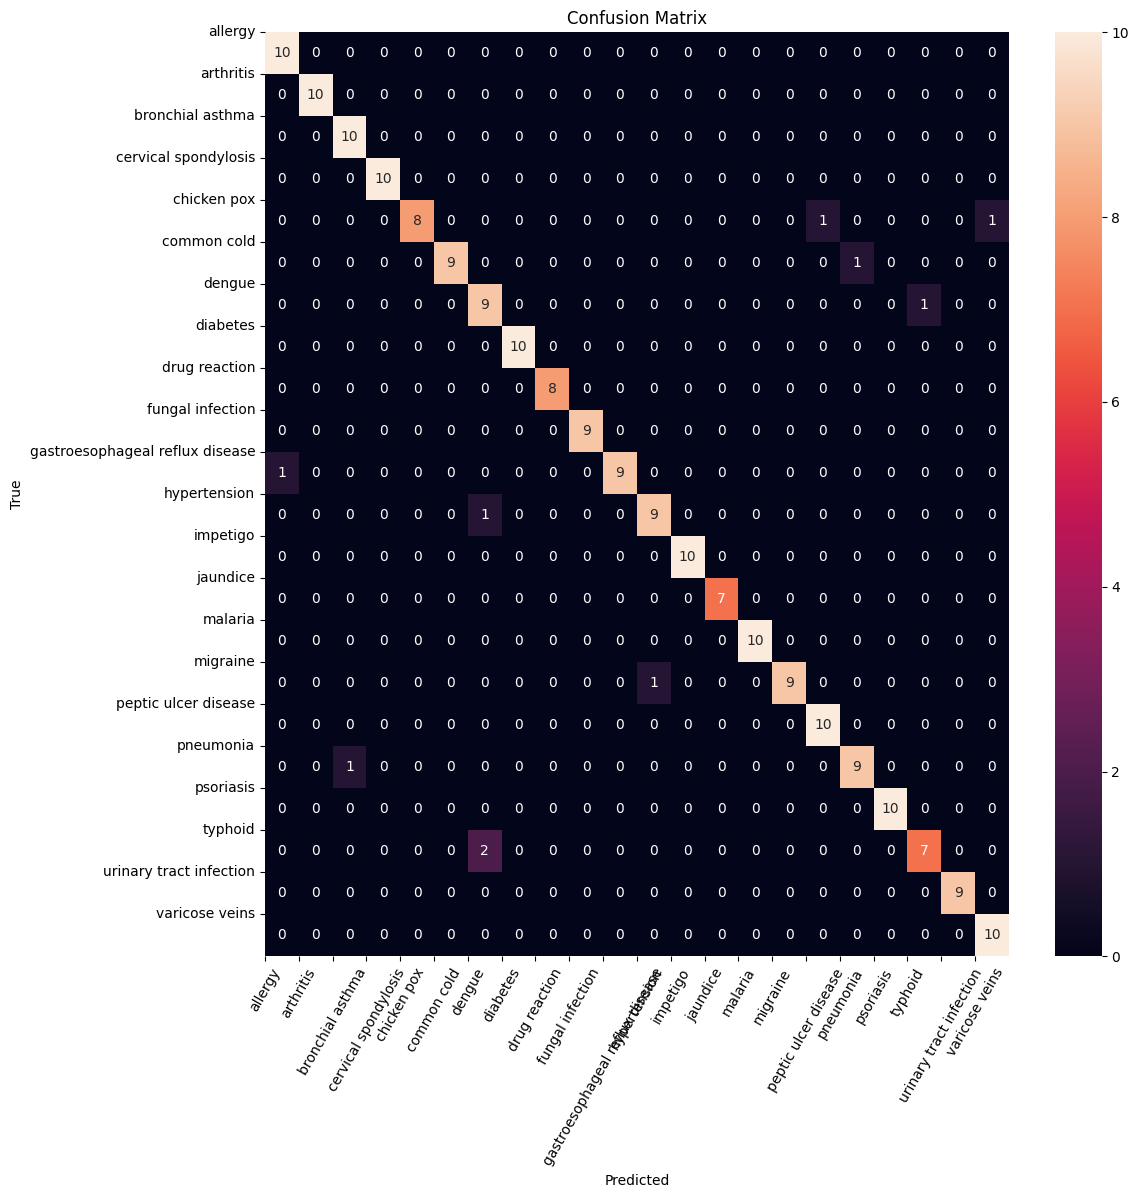

In [ ]:
pr = trainer.predict(test_ds)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(pr.label_ids, np.argmax(pr.predictions, axis=1))
plt.figure(figsize=(12, 12))
sns.heatmap(confusion, annot=True)

plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=60)
plt.yticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



The model sometimes gets confused with symptoms that appear in several categories, such as chicken pox fever, dengue fever, or common cold

In [ ]:
def make_diagnose(text):
  inputs = tokenizer(text, return_tensors='pt')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)


  with torch.no_grad():
    outputs = model1(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

  #print(predictions.item())
  print(f'this symptoms could be {label_encoder.inverse_transform([predictions.item()])}')


In [ ]:
text='My nose is stuffy and I sneeze all the time and my eyes are red.'
make_diagnose(text)

this symptoms could be ['allergy']


# Model Electra feature extraction


Same steps as for Bert

In [ ]:
token_train=tokenizer(dataset['train']['text'], padding=True, truncation=True, return_tensors='pt')
token_test=tokenizer(dataset['test']['text'], padding=True, truncation=True, return_tensors='pt')

In [ ]:
model1 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
with torch.no_grad():
    hidden_train = model1(**token_train)
    hidden_test = model1(**token_test)

In [ ]:
classifier = LogisticRegression()
classifier.fit(cls_train, dataset['train']['label'])
y_pred = classifier.predict(cls_test)
accuracy = accuracy_score(dataset['test']['label'], y_pred)
print(accuracy)

0.8254716981132075


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Summary


Both models performed well in classifying symptoms both on the test set and on new examples from outside the set. The distilbert model is faster and achieves lower loss compared to Electra and this may be due to the size of the model, but looking at the classification accuracy and taking into account 22 possible categories, it can be seen that the models were very well prepared. For both models, fine tuning works best, but with the use of feature extraction, classification using models such as linear regression or random forest is possible, but with significantly lower accuracy compared to the previous method.